In [2]:
import pandas as pd
import numpy as np
import os
import pickle as pkl
import h5py
import sys
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import kstest,ks_2samp
import scipy

C:\Users\faizaan09\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [1]:
data_dir = "./data/clusterdata-2011-2/"

task_events_header = ['timestamp','missing_info', 'job_id','task_index','machine_id','event_type',
                      'user_name','sched_class','priority','cpu_req','ram_req','space_req','diff_machine']

machine_events_header = ['timestamp','machine_id','event_type','platform_id','cpu_cap','mem_cap']


In [105]:
df = pd.read_csv(data_dir+"task_events/part-00000-of-00500.csv.gz",header=None)
df.columns = task_events_header
df = df[['job_id','cpu_req','ram_req','space_req']]

In [106]:
for i in tqdm(range(1,10)):
    temp = pd.read_csv(data_dir + "task_events/part-%05d-of-00500.csv.gz" % i,header=None)
    temp.columns = task_events_header
    temp = temp[['job_id','cpu_req','ram_req','space_req']]
    df = pd.concat([df,temp])

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.53it/s]


In [107]:
df.dropna(axis=0,how='any',inplace=True)
sys.getsizeof(df) / 1024 / 1024 / 1024, df.shape

(0.06808212399482727, (1827565, 4))

In [108]:
df.head()

,job_id,cpu_req,ram_req,space_req
2,3418314,0.12500,0.07446,0.000424
3,3418314,0.12500,0.07446,0.000424
45,3418368,0.03125,0.08691,0.000455
46,3418368,0.03125,0.08691,0.000455
47,3418368,0.03125,0.08691,0.000455


In [100]:
# hd = pd.HDFStore('./data/all_task_events.h5')
# hd.put('all_task_events',df)
# hd.close()

In [109]:
mean = {}
mean['cpu'] = df['cpu_req'].mean()
mean['ram'] = df['ram_req'].mean()
mean['space'] = df['space_req'].mean()
std = {}
std['cpu'] = df['cpu_req'].std()
std['ram'] = df['ram_req'].std()
std['space'] = df['space_req'].std()

with open('./data/task_event_stats.pkl','wb') as f:
    pkl.dump((mean,std),f)

# df['cpu_req'] = (df['cpu_req']-mean['cpu'])/std['cpu']
# df['ram_req'] = (df['ram_req']-mean['ram'])/std['ram']
# df['space_req'] = (df['space_req']-mean['space'])/std['space']

In [110]:
scaler = StandardScaler()

df['cpu_req'] = pd.Series(scaler.fit_transform(df['cpu_req'].values.reshape(-1, 1)).squeeze())
df['ram_req'] = pd.Series(scaler.fit_transform(df['ram_req'].values.reshape(-1, 1)).squeeze())
df['space_req'] = pd.Series(scaler.fit_transform(df['space_req'].values.reshape(-1, 1)).squeeze())

In [111]:
df.head()

,job_id,cpu_req,ram_req,space_req
2,3418314,-0.150537,1.989888,0.198723
3,3418314,-0.150537,1.989888,0.198723
45,3418368,0.730898,2.359508,0.262981
46,3418368,0.730898,2.359508,0.262981
47,3418368,0.730898,2.359508,0.262981


In [12]:
# df['cpu_req'] = df['norm_cpu']
# df['ram_req'] = df['norm_ram']
# df['space_req'] = df['norm_space']

# df.drop(['norm_cpu','norm_ram', 'norm_space'],axis=1,inplace=True)

In [112]:
grouped = df.groupby('job_id').agg('sum')

In [113]:
grouped['resource_req'] = (grouped['cpu_req'] + grouped['ram_req'] + grouped['space_req'])/3

In [114]:
grouped.head()

,cpu_req,ram_req,space_req,resource_req
job_id,,,,
3418309,1.461796,-0.133310,-0.738957,0.196510
3418314,-0.602150,5.423557,0.414292,1.745233
3418319,-0.301075,1.456022,0.016847,0.390598
3418324,-0.301075,3.930130,0.462943,1.363999
3418329,2.192694,-1.205794,-1.166159,-0.059753


In [115]:
grouped.drop(['cpu_req','ram_req','space_req'],axis=1,inplace=True)


In [116]:
temp = grouped.copy()
# grouped = temp.copy()

In [117]:
q1 = grouped['resource_req'].quantile(0.25)
q3 = grouped['resource_req'].quantile(0.75)
iqr = q3-q1
grouped = grouped[(grouped['resource_req'] > (q1-1.5*iqr) ) & (grouped['resource_req'] < (q3+1.5*iqr))]

In [118]:
grouped['resource_req'].describe()

count    12071.000000
mean         0.830850
std          2.420205
min         -6.955470
25%         -0.898673
50%          0.409772
75%          2.034096
max          9.098997
Name: resource_req, dtype: float64

In [119]:
machine_attrs = pd.read_csv(data_dir+"machine_events/part-00000-of-00001.csv.gz",header=None)
machine_attrs.columns = machine_events_header
machine_attrs = machine_attrs[machine_attrs['event_type'] == 0]
machine_attrs.drop(['platform_id','event_type','timestamp'],axis=1,inplace=True)
machine_attrs.dropna(inplace=True)
machine_attrs.drop_duplicates('machine_id',inplace=True)


In [120]:
scaler = StandardScaler()

machine_attrs['cpu_cap'] = pd.Series(scaler.fit_transform(machine_attrs['cpu_cap'].values.reshape(-1, 1)).squeeze())
machine_attrs['mem_cap'] = pd.Series(scaler.fit_transform(machine_attrs['mem_cap'].values.reshape(-1, 1)).squeeze())
machine_attrs.dropna(inplace=True)


In [121]:
machine_attrs['res_cap'] = (machine_attrs['cpu_cap'] + machine_attrs['mem_cap'])/2
machine_attrs.drop(['cpu_cap','mem_cap'],axis=1,inplace=True)

In [122]:
q1 = machine_attrs['res_cap'].quantile(0.25)
q3 = machine_attrs['res_cap'].quantile(0.75)
iqr = q3-q1
machine_attrs = machine_attrs[(machine_attrs['res_cap'] > (q1-1.5*iqr) ) & (machine_attrs['res_cap'] < (q3+1.5*iqr))]

In [123]:
machine_attrs['res_cap'].value_counts()

-0.043695    6677
-0.664956    3840
 0.575827     993
-0.975834      54
-1.207379       5
-1.131075       1
Name: res_cap, dtype: int64

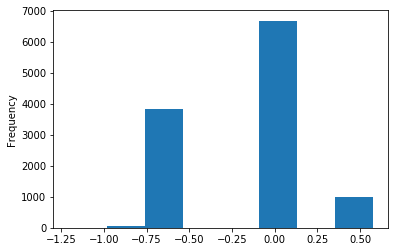

In [124]:
machine_attrs['res_cap'].plot.hist(bins=8)
plt.show()

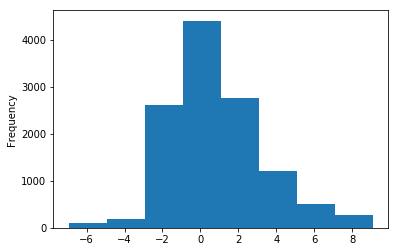

In [126]:
grouped['resource_req'].plot.hist(bins=8)

plt.show()

In [127]:
hist, bin_edges = np.histogram(machine_attrs['res_cap'],8)

mac_hist = []
for ind,count in enumerate(hist):

    bin_val = (bin_edges[ind] + bin_edges[ind+1])/2 
    mac_hist.extend([bin_val]*count)

In [128]:
hist, bin_edges = np.histogram(grouped['resource_req'],8)

job_hist = []
for ind,count in enumerate(hist):

    bin_val = (bin_edges[ind] + bin_edges[ind+1])/2 
    job_hist.extend([bin_val]*(count))

In [129]:
print(len(job_hist),len(mac_hist))
ks_2samp(job_hist,mac_hist)

12071 11570


Ks_2sampResult(statistic=0.6735980009375528, pvalue=0.0)

We use the table found on http://www.real-statistics.com/statistics-tables/kolmogorov-smirnov-table/ to find the threshold to accept/reject the null hypothesis. <br><br>
For n $\approx$ 11500, the threshold is 0.012 <br><br>
As we can clearly see that the K-S statistic 0.6736 $>=$ 0.012 and also the returned p-value is 0, we **reject** the hypothesis that the machines (based on resource capacity) and jobs (based on resource requirements) come from the same distribution 